## Please follow https://mondaic.com/docs/0.12.1/installation to install salvus and run this notebook under salvus environment.

In [1]:
import os
from salvus.toolbox import toolbox
SALVUS_FLOW_SITE_NAME = os.environ.get("SITE_NAME", "local_server")
from salvus.flow import api
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import time
import xarray as xr
from salvus.flow import simple_config as config
import salvus.namespace as sn
from pyasdf import ASDFDataSet
import gstools as gs
import warnings
warnings.filterwarnings("ignore")

def generate_2dGRF( ncorrx, ncorry, sigma, nx, ny, seed=-1):

    # Von-Karman type random field, function provided by Jorge C. Castellanos (jccastellanos@google.com)
    # -----------------------------------
    # Generating the random perturbations
    # -----------------------------------
    # The perturbation parameters are:
    #      ax - correlation length/box length in the x-direction
    #      ay - correlation length/box length in the z-direction
    #      sigma - standard deviation
    #      nx - # of grids in x direction
    #      ny - # of grids in y direction
    if seed>=0:

        np.random.seed(seed)


    deltax = 1/nx
    deltay = 1/ny
    ax = ncorrx/nx
    az = ncorry/ny

    M = 2 * ny
    N = 2 * nx

    dP = 2 * np.random.rand(N, M) - 1
    Y2 = np.fft.fft2(dP)

    kx1 = np.mod(1 / 2 + (np.arange(0, M)) / M, 1) - 1 / 2
    kx = kx1 * (2 * np.pi / deltax)
    kz1 = np.mod(1 / 2 + (np.arange(0, N)) / N, 1) - 1 / 2
    kz = kz1 * (2 * np.pi / deltay)
    [KX, KZ] = np.meshgrid(kx, kz)

    K_sq = KX**2 * ax ** 2 + KZ**2 * az**2
    P_K = (ax * az) / ((1 + K_sq)**(3 / 2))

    Y2 = Y2 * np.sqrt(P_K)
    dP_New = np.fft.ifft2(Y2)

    test = np.real(dP_New[0:N,0:M])
    test = sigma / np.std(test.flatten()) * test

    Mid_M = int(np.floor(M / 4))
    Mid_N = int(np.floor(N / 4))
    M = int(M / 2)
    N = int(N / 2)
    dV = test[Mid_N : Mid_N + N, Mid_M : Mid_M + M]

    return dV

In [2]:
# define source parameters, check Salvus website for more info
SRC_FREQ = 8.0
MAX_FREQ = 10.0
SIMULATION_TIME = 5.0
FIELD = "phi" # acoustic
# Wavelet:
wavelet = config.stf.Ricker(center_frequency=SRC_FREQ)


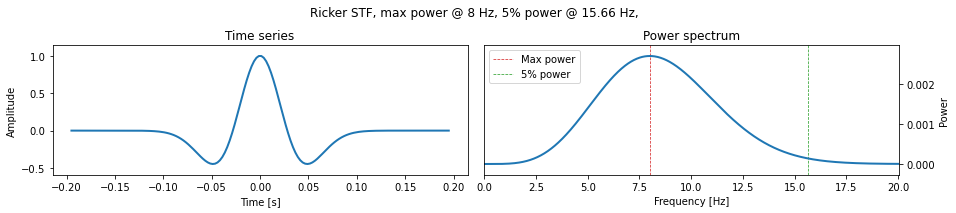

In [3]:
wavelet.plot()

In [4]:
nx, ny = 64, 64
x = np.linspace(-5e3, 5e3, nx)
y = np.linspace(-5e3, 5e3, ny)

xx, yy = np.meshgrid(x, y, indexing="ij")

vp0 = 3000.0 * np.ones_like(xx)
rho0 = 2200.0 * np.ones_like(xx)

# dataset of 50 simulations
N = 1
dVset = np.zeros((N, nx, ny))
ncorrx, ncorry, sigma = 10, 10, 5
for i in range(N):
    dVset[i,:,:] = generate_2dGRF( ncorrx, ncorry, sigma, nx, ny)

# source location
srcxy = (np.random.random((N,2))-0.5)/0.5*5000

# store dV and source
input_a_dir = './input_a'
input_u_dir = './input_u'
if not os.path.exists(input_a_dir):
    os.mkdir(input_a_dir)
if not os.path.exists(input_u_dir):
    os.mkdir(input_u_dir)
    
    
# np.save(os.path.join(input_a_dir,'dV.npy'), dVset)
# np.save(os.path.join(input_a_dir,'srcxy.npy'), srcxy)


# dVset = np.load(os.path.join(input_a_dir,'dV.npy'))
# srcxy = np.load(os.path.join(input_a_dir,'srcxy.npy'))

# Receivers:
recx = xx.flatten()
recy = yy.flatten()

recs = [
        config.receiver.cartesian.Point2D(
            x=recx[_j], y=recy[_j], station_code=f"{_j:05d}", fields=[FIELD]
            )
        for _j in range(0, len(recx), 1)
        ]




In [5]:
for i in range(N):
    src = config.source.cartesian.ScalarPoint2D(
        source_time_function=wavelet, x=srcxy[i,0], y=srcxy[i,1],  f=1.0)
    
    dV = dVset[i,:,:]
    
    ds = xr.Dataset(
        data_vars={
            "vp": (["x", "y"], vp0 + (vp0 * (dV / 100))),
            "rho": (["x", "y"], rho0 + (rho0 * (dV / 100))),
        },
        coords={"x": x, "y": y},
      )

    mesh = toolbox.mesh_from_xarray(
        model_order=4,
        data=ds,
        slowest_velocity="vp",
        maximum_frequency=MAX_FREQ,
        elements_per_wavelength=1.5,
        absorbing_boundaries=(["x0", "x1", "y0", "y1"], 0),
    )

    s = config.simulation.Waveform(mesh=mesh, sources=src, receivers=recs)

    # Set end time:
    s.physics.wave_equation.end_time_in_seconds = SIMULATION_TIME

    # Initialize first-order absorbing boundary conditions:
    boundaries = config.boundary.Absorbing(
        side_sets=["x0", "x1", "y0", "y1"], taper_amplitude=SRC_FREQ, width_in_meters=0.0
    )

    # Add the boundaries to the parameter file:
    s.physics.wave_equation.boundaries = [boundaries]

    # Wavefield output format:
    s.output.point_data.format = "asdf"

    s.validate()
    
    t1=time.time()
    api.run(
        input_file=s,
        ranks=4,
        site_name=SALVUS_FLOW_SITE_NAME,
        get_all=True,
        output_folder="output_tmp",
        overwrite=True,
    )
    print(time.time()-t1)
    
    a = ASDFDataSet('output_tmp/' + "receivers.h5", mode="r")
    
    t1=time.time()
    tmp=np.zeros((nx*ny, 500))
    flag = 0
    for ii in a.waveforms:
        tmp[flag,:] = ii['phi'][0].resample(100).data[:500] # 100 Hz, 500 samples, 5 sec
        flag +=1
    print(time.time()-t1)
    np.save(os.path.join(input_u_dir,'No'+str(i)+'.npy'), tmp.reshape(nx,ny,500))
    os.system("rm -rf output_tmp")

Job `job_2206081651277570_9137ee9b8d` running on `local_server` with 4 rank(s).
Site information:
  * Salvus version: 0.11.36
  * Floating point size: 32


Solving forward problem/Computing forward wavefield:   0%|          | 0/1036 [00:00<?, ?it/s]

* Downloaded 28.0 MB of results to `output_tmp`.
* Total run time: 18.41 seconds.
* Pure simulation time: 16.17 seconds.
18.416651725769043
13.858757972717285
